In [1]:
import pathlib
import os
import tqdm
import argparse
import math
from ast import literal_eval

import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch
import dataset
import timm
from PIL import Image
from sklearn.cluster import KMeans

KeyboardInterrupt: 

In [2]:
dataset_path = "C:\\Users\had-int22\PycharmProjects\Pytorch_AD\data\package_square"
config_path = "C:\\Users\had-int22\PycharmProjects\Pytorch_AD\FastFlow\configs\wide_resnet50_2.yaml"

parser = argparse.ArgumentParser()
parser.add_argument(
    "-cfg", "--config", type=str, required=True, help="path to config file"
)
parser.add_argument('--name', type=str, required=True, help='dataset name')
parser.add_argument("--data", type=str, required=True, help="path to dataset folder")
parser.add_argument("-cat", "--category", type=str, required=True)
parser.add_argument('--valid', type=str, help='validation category')
parser.add_argument('--color', type=str, choices=['rgb', 'gray'])
parser.add_argument('-p', '--patchsize', type=int, help='patch size. By default, patch separation will not do')
parser.add_argument('--random', action='store_true', help='random patch sampling')
parser.add_argument('--mask', action='store_true', help='target mask')

args = parser.parse_args(['--config', config_path, '--name', 'package', '--data', dataset_path, '-cat', 'cut', '--valid', 'cut'])

In [3]:
# data loaderの作成
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

train_dataloader = dataset.build_train_data_loader(args=args, config=config)

In [4]:
# load model
resnet50 = timm.create_model(
    model_name=config['backbone_name'],
    pretrained=True,
    features_only=True,
    out_indices=[4]
)
resnet50.eval()
channels = resnet50.feature_info.channels()
scale = resnet50.feature_info.reduction()

In [5]:
input_size = [math.ceil(240/scale[0]), math.ceil(320/scale[0])]
input_size

[8, 10]

In [6]:
gap = torch.nn.AvgPool2d(kernel_size=input_size, stride=input_size)

In [7]:
torch.cuda.empty_cache()

In [8]:
torch.cuda.memory_allocated()

0

In [9]:
image_files = train_dataloader.dataset.image_files

In [11]:
image_files

[WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/package_square/cut/OK_Clip/1_Cam1_000181.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/package_square/cut/OK_Clip/1_Cam1_000182.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/package_square/cut/OK_Clip/1_Cam1_000183.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/package_square/cut/OK_Clip/1_Cam1_000184.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/package_square/cut/OK_Clip/1_Cam1_000185.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/package_square/cut/OK_Clip/1_Cam1_000186.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/package_square/cut/OK_Clip/1_Cam1_000187.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/package_square/cut/OK_Clip/1_Cam1_000188.jpg'),
 WindowsPath('C:/Users/had-int22/PycharmProjects/Pytorch_AD/data/package_square/cut/OK_Clip/1_Ca

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


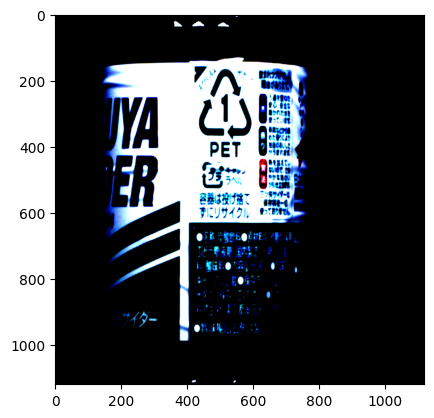

In [14]:
data = next(iter(train_dataloader))
img = data[0].permute([1, 2, 0]).numpy()
plt.imshow(img)

In [12]:
head_indices = ['00182', '00183', '00184', '00185', '00191']
name = ['1_' + 'Cam1_' + path + '.jpg' for path in head_indices]
name

['1_Cam1_00182.jpg',
 '1_Cam1_00183.jpg',
 '1_Cam1_00184.jpg',
 '1_Cam1_00185.jpg',
 '1_Cam1_00191.jpg']

In [13]:
feature_list = []
resnet50.cuda()
for data in tqdm.tqdm(train_dataloader):
    data = data.cuda()
    outputs = resnet50(data)[0].detach().cpu()
    outputs = gap(outputs)[..., 0, 0]
    feature_list.append(outputs)

100%|██████████| 1621/1621 [00:49<00:00, 32.92it/s]


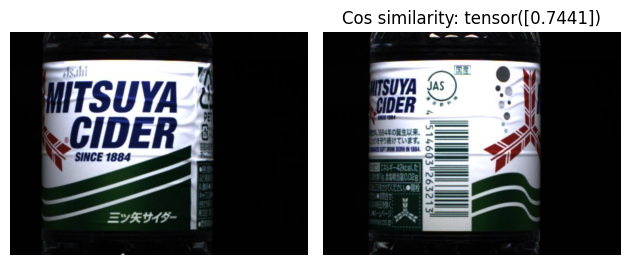

In [42]:
x_idx = 15
y_idx = 7

x = feature_list[x_idx]
y = feature_list[y_idx]
x_path = image_files[x_idx]
y_path = image_files[y_idx]
path_list = [x_path, y_path]

cos = torch.nn.CosineSimilarity(dim=1)
out = cos(x, y)

figure, ax = plt.subplots(1, 2)
for i in range(2):
    ax[i].imshow(Image.open(path_list[i]))
    ax[i].axis('off')
plt.title(f'Cos similarity: {out}')
plt.tight_layout()

K-centerのサンプル

In [49]:
def gen(n=2, k=3):
    """1x1の正方形内の点をランダムにn個サンプリングし，適当にスライドするという手順を繰り返し，k個のクラスタPを作成
    Args:
        n: クラスタ内のサンプル数
        k: クラスタ数

    Returns:
        P: クラスタ, (n*k, 2), J次元空間内のベクトルを考える際は(n*k, J)となる．
    """
    P = np.random.random((n, 2)) + np.random.randint(0, 10, 2)
    for i in range(k - 1):
        pts = np.random.random((n, 2)) + np.random.randint(0, 10, 2)
        P = np.concatenate((P, pts))
    return P

(6, 2)

1.2403630009006354


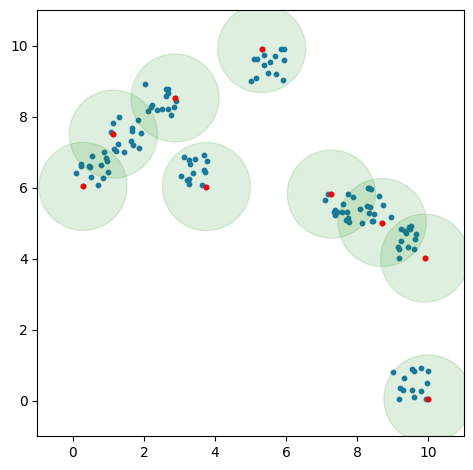

In [51]:
def greedy_2_approx(V, k):
    """greedy法にもとづき，中心点cを選ぶ．具体的には，まずランダムに点を一つ選びSに追加し，その後，S内の点から最も離れた点をSに追加するという手順を繰り返す．
    Args:
        V: クラスタリング対象のベクトル集合
        k: クラスタ数

    Returns:

    """

    # Vからランダムに1つの点を選択し，Sに追加する．
    S = [np.random.randint(len(V))]
    while len(S) < k:
        dists = []
        # V内の各点について，S内のすべての点との距離(L2ノルム)を評価し，その中の最小距離をdistsに格納(S内のどの点からも離れている点を選びたい)
        for i in range(len(V)):
            dists.append(min(np.linalg.norm(V[i] - V[s]) for s in S))

        # 最小距離が最も大きい点(S内のどの点からも離れている点)のindexをSに追加
        S.append(np.argmax(dists))
    return S


def radius(V, S):
    return max(min(np.linalg.norm(V[i] - V[s]) for s in S) for i in range(len(V)))


def draw_circle(V, S, r):
    for s in S:
        c = plt.Circle(V[s], r, alpha=0.125, color='g', edgecolor=None)
        plt.gca().add_artist(c)
    plt.gca().scatter(V[S, 0], V[S, 1], color='r', s=10)
    print(r)


def draw(V, S):
    plt.gca().scatter(V[:, 0], V[:, 1], s=10)
    draw_circle(V, S, radius(V, S))

    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.gca().set_xlim([-1, 11])
    plt.gca().set_ylim([-1, 11])

n, k = 15, 9
V = gen(n, k * 1)
S = greedy_2_approx(V, k)
draw(V, S)
plt.savefig('kcen.png', bbox_inches='tight')
plt.show()